In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch

In [2]:
from rllib_emecom.utils.experiment_utils import initialise_ray
initialise_ray()

pygame 2.3.0 (SDL 2.24.2, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/ray/anaconda3/lib/python3.8/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
2023-10-16 15:12:21,652	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.8.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-10-16 15:12:24,140	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.8.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/ray/anaconda3/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/home/ray/anaconda3/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:58: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version

In [3]:
from IPython.display import clear_output
from ray.rllib.algorithms.algorithm import Algorithm

In [4]:
runs_dir = 'ray_results/goal_comms_gridworld/goal_comms_gridworld'
# run = 'PPO_goal_comms_gridworld_970ba_00000_0_2023-10-13_22-33-54'
# ckpt = 'checkpoint_000099'
# run = 'PPO_goal_comms_gridworld_ce299_00000_0_2023-10-15_23-01-42'
# ckpt = 'checkpoint_000099'
run = 'PPO_goal_comms_gridworld_74764_00000_0_2023-10-16_13-18-11'
ckpt = 'checkpoint_000030'
algo = Algorithm.from_checkpoint(f'{runs_dir}/{run}/{ckpt}')
clear_output()
print('Loaded checkpoint.')

Loaded checkpoint.


In [17]:
def eval(algo, n_evals: int = 1):
    mean_reward = 0
    mean_episode_length = 0

    for _ in range(n_evals):
        eval_results = algo.evaluate()

        mean_reward += eval_results['evaluation']['sampler_results']['episode_reward_mean']
        mean_episode_length += eval_results['evaluation']['sampler_results']['episode_len_mean']

    mean_reward /= n_evals
    mean_episode_length /= n_evals

    print(f'Mean reward: {mean_reward}, Mean episode length: {mean_episode_length}')

    return eval_results, mean_reward, mean_episode_length

In [22]:
eval_results, *_ = eval(algo)

Mean reward: -5.16, Mean episode length: 4.76


In [20]:
from rllib_emecom.utils.video_utils import embed_mp4
media = eval_results['evaluation']['sampler_results']['episode_media']
video = None
for k in media:
    if k.startswith('env'):
        video, *_ = media[k]
        break
if video:
    embed_mp4(video._path)

In [5]:
from rllib_emecom.utils.comms_data_collection import CollectCommsDataCallback
from ray.rllib.evaluation.worker_set import WorkerSet

In [24]:
eval_config = algo.evaluation_config.copy(copy_frozen=False)
eval_config.callbacks_class = CollectCommsDataCallback

eval_worker_set = WorkerSet(
    env_creator=algo.env_creator,
    validate_env=None,
    default_policy_class=algo.get_default_policy_class(algo.config),
    config=eval_config,
    num_workers=0,
    logdir=algo.logdir,
)

worker = eval_worker_set.local_worker()
algo.evaluation_workers = eval_worker_set
collect_comms_data_cb = worker.callbacks
collect_comms_data_cb.data.clear()

2023-10-16 15:29:19,758	WARNING algorithm_config.py:2574 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.


Building MACRL module...
Comms spec: {'message_dim': 3, 'comm_channels': {'agent_0': ['agent_1', 'agent_2'], 'agent_1': ['agent_0', 'agent_2'], 'agent_2': ['agent_0', 'agent_1']}, 'channel_fn': 'gumbel_softmax', 'channel_fn_config': {'temperature': 2.0, 'temperature_annealing': False, 'annealing_start_iter': 0, 'n_anneal_iterations': 500, 'final_temperature': 0.5, 'channel_noise': 0.25, 'channel_activation': 'tanh'}, 'n_agents': 3}
Communication channel function: <rllib_emecom.macrl.comms.gumbel_softmax.GumbelSoftmaxCommunicationChannel object at 0x7ff2986b7190>


In [25]:
macrl_module = worker.get_policy('default_policy').model
channel_fn = macrl_module.comm_channel_fn
channel_fn.temperature

2.0

In [28]:
macrl_module.comm_channel_fn.disable()
eval(algo, n_evals=10)
macrl_module.comm_channel_fn.enable()
collect_comms_data_cb.data.clear()

Mean reward: -13.703999999999999, Mean episode length: 8.736


In [ ]:
macrl_module.comm_channel_fn.enable()
macrl_module.comm_channel_fn.set_force_eval(True)
_ = eval(algo, n_evals=10)

In [31]:
len(collect_comms_data_cb.data)

1316

In [32]:
collect_comms_data_cb.data[0]

{'comms': {'agent_0': {'agent_1': array([1., 0., 0.], dtype=float32),
   'agent_2': array([1., 0., 0.], dtype=float32)},
  'agent_1': {'agent_0': array([0., 0., 1.], dtype=float32),
   'agent_2': array([0., 1., 0.], dtype=float32)},
  'agent_2': {'agent_0': array([1., 0., 0.], dtype=float32),
   'agent_1': array([1., 0., 0.], dtype=float32)}},
 'total_env_steps': 1,
 'total_reward': -1.0,
 'episode_id': 246897023471146733,
 'env_index': 0,
 'last_obs': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0

In [33]:
df = collect_comms_data_cb.get_dataframe()
df['goal_id'] = df['goal_vec'].apply(lambda x: np.argmax(x))
df.head()

,receiver,sender,goal_x,goal_y,pos_x,pos_y,world_w,world_h,receiver_action,msg,goal_vec,msg_0,msg_1,msg_2,goal_grid_idx,pos_grid_idx,goal_id
0,agent_0,agent_2,3,2,3,2,5,5,4,0,"[1, 0, 0]",1.0,0.0,0.0,13,13,0
1,agent_1,agent_0,4,4,3,1,5,5,4,2,"[0, 1, 0]",0.0,0.0,1.0,24,8,1
2,agent_2,agent_1,4,3,3,3,5,5,4,0,"[0, 0, 1]",1.0,0.0,0.0,19,18,2
3,agent_0,agent_2,3,2,2,2,5,5,3,0,"[1, 0, 0]",1.0,0.0,0.0,13,12,0
4,agent_1,agent_0,4,4,3,2,5,5,4,2,"[0, 1, 0]",0.0,0.0,1.0,24,13,1


In [39]:
df[df['goal_vec'].apply(lambda x: np.sum(x) > 1)]

,receiver,sender,goal_x,goal_y,pos_x,pos_y,world_w,world_h,receiver_action,msg,goal_vec,msg_0,msg_1,msg_2,goal_grid_idx,pos_grid_idx,goal_id
0,agent_0,agent_2,3,2,3,2,5,5,4,0,"[1, 0, 0]",1.0,0.0,0.0,13,13,0
1,agent_1,agent_0,4,4,3,1,5,5,4,2,"[0, 1, 0]",0.0,0.0,1.0,24,8,1
2,agent_2,agent_1,4,3,3,3,5,5,4,0,"[0, 0, 1]",1.0,0.0,0.0,19,18,2
3,agent_0,agent_2,3,2,2,2,5,5,3,0,"[1, 0, 0]",1.0,0.0,0.0,13,12,0
4,agent_1,agent_0,4,4,3,2,5,5,4,2,"[0, 1, 0]",0.0,0.0,1.0,24,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935,agent_2,agent_1,4,0,4,0,5,5,4,0,"[1, 0, 0]",1.0,0.0,0.0,4,4,0
3937,agent_1,agent_0,1,2,1,3,5,5,2,2,"[0, 1, 0]",0.0,0.0,1.0,11,16,1
3940,agent_1,agent_0,1,2,1,2,5,5,2,1,"[0, 1, 0]",0.0,1.0,0.0,11,11,1
3943,agent_1,agent_0,1,2,1,1,5,5,2,1,"[0, 1, 0]",0.0,1.0,0.0,11,6,1


In [67]:
agent_df

,receiver,sender,goal_x,goal_y,pos_x,pos_y,world_w,world_h,receiver_action,msg,goal_vec,msg_0,msg_1,msg_2,goal_grid_idx,pos_grid_idx,goal_id
2,agent_2,agent_1,4,3,3,3,5,5,4,0,"[0, 0, 1]",1.0,0.0,0.0,19,18,2
5,agent_2,agent_1,4,3,4,3,5,5,4,0,"[0, 0, 1]",1.0,0.0,0.0,19,19,2
8,agent_2,agent_1,4,3,4,3,5,5,1,2,"[0, 0, 1]",0.0,0.0,1.0,19,19,2
11,agent_2,agent_1,4,3,4,4,5,5,1,2,"[0, 0, 1]",0.0,0.0,1.0,19,24,2
14,agent_2,agent_1,4,3,4,4,5,5,1,0,"[0, 0, 1]",1.0,0.0,0.0,19,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935,agent_2,agent_1,4,0,4,0,5,5,4,0,"[1, 0, 0]",1.0,0.0,0.0,4,4,0
3938,agent_2,agent_1,2,1,2,2,5,5,2,1,"[1, 0, 1]",0.0,1.0,0.0,7,12,0
3941,agent_2,agent_1,2,1,2,1,5,5,2,1,"[1, 0, 1]",0.0,1.0,0.0,7,7,0
3944,agent_2,agent_1,2,1,2,2,5,5,1,0,"[1, 0, 1]",1.0,0.0,0.0,7,12,0


In [71]:
agent_df = df[df['sender'] == 'agent_0']
agent_df

,receiver,sender,goal_x,goal_y,pos_x,pos_y,world_w,world_h,receiver_action,msg,goal_vec,msg_0,msg_1,msg_2,goal_grid_idx,pos_grid_idx,goal_id
1,agent_1,agent_0,4,4,3,1,5,5,4,2,"[0, 1, 0]",0.0,0.0,1.0,24,8,1
4,agent_1,agent_0,4,4,3,2,5,5,4,2,"[0, 1, 0]",0.0,0.0,1.0,24,13,1
7,agent_1,agent_0,4,4,4,2,5,5,4,2,"[0, 1, 0]",0.0,0.0,1.0,24,14,1
10,agent_1,agent_0,4,4,4,3,5,5,1,2,"[0, 1, 0]",0.0,0.0,1.0,24,19,1
13,agent_1,agent_0,4,4,4,4,5,5,1,2,"[0, 1, 0]",0.0,0.0,1.0,24,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,agent_1,agent_0,0,3,0,3,5,5,1,1,"[0, 0, 1]",0.0,1.0,0.0,15,15,2
3937,agent_1,agent_0,1,2,1,3,5,5,2,2,"[0, 1, 0]",0.0,0.0,1.0,11,16,1
3940,agent_1,agent_0,1,2,1,2,5,5,2,1,"[0, 1, 0]",0.0,1.0,0.0,11,11,1
3943,agent_1,agent_0,1,2,1,1,5,5,2,1,"[0, 1, 0]",0.0,1.0,0.0,11,6,1


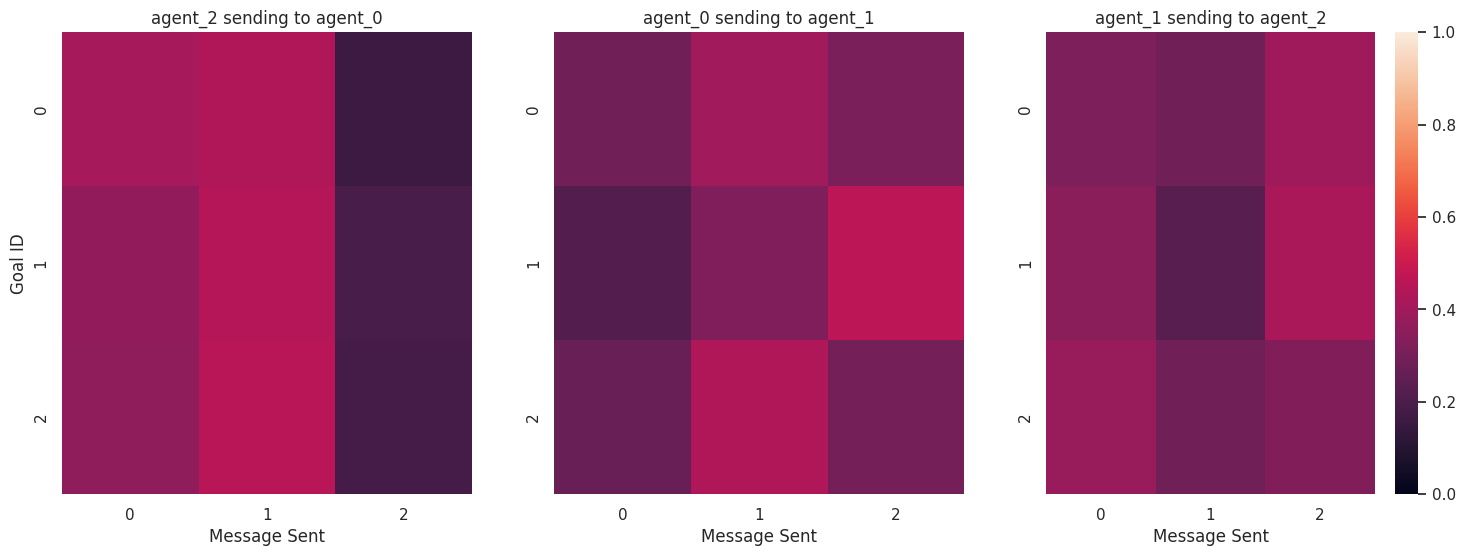

In [83]:
n_msgs = macrl_module.message_dim
n_goals = macrl_module.n_agents

agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(6 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df['sender'] == agent]
    recvs = agent_df['receiver'].unique()
    assert recvs.size == 1
    recv = recvs[0]

    agent_df = agent_df.groupby('goal_id')['msg'].value_counts(normalize=True).unstack()
    agent_df = agent_df.fillna(0)
    counts = np.zeros((n_goals, n_msgs))
    for msg in agent_df.columns:
        for action in agent_df.index:
            counts[action, msg] = agent_df.loc[action, msg]

    sns.heatmap(counts, ax=axs[i], vmin=0, vmax=1, cbar=i == len(agents) - 1)
    axs[i].set_title(f'{agent} sending to {recv}')
    if i > 0:
        axs[i].set_ylabel('')
    else:
        axs[i].set_ylabel('Goal ID')
    axs[i].set_xlabel('Message Sent')

/tmp/ipykernel_264303/4277009052.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

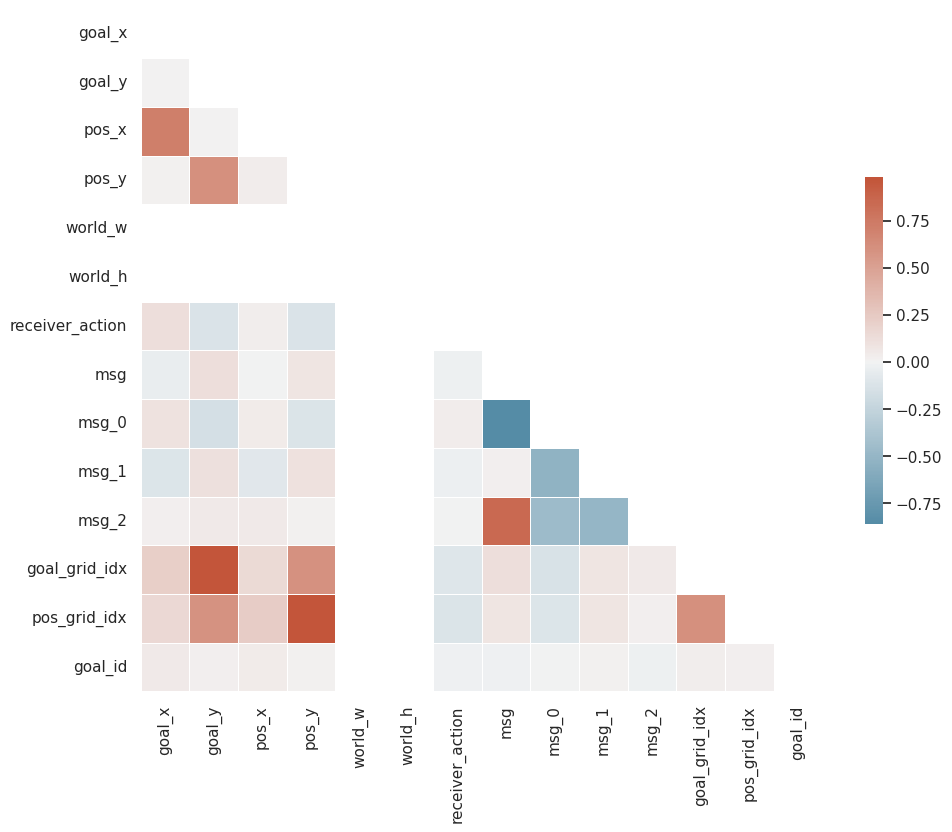

In [82]:
corr = df.corr()
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

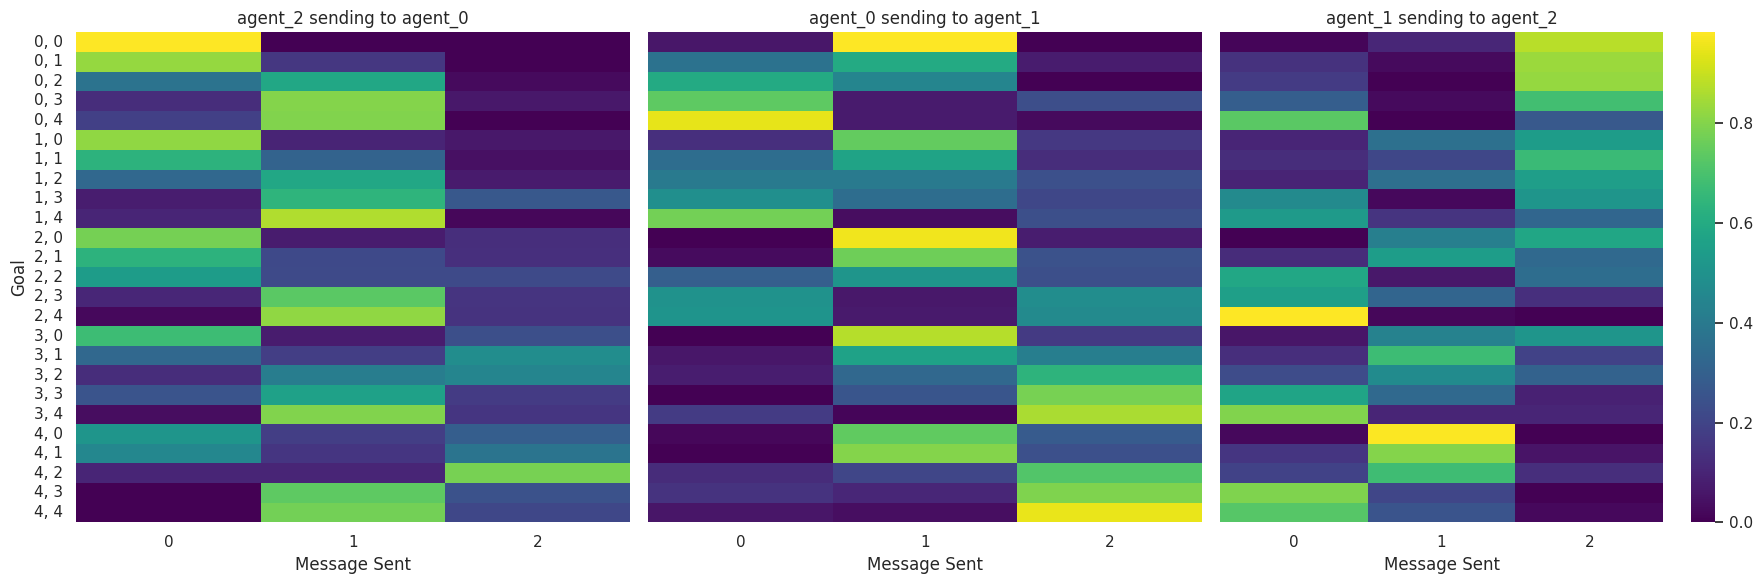

In [45]:
world_w, world_h = eval_config.env_config['world_shape']
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(6 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df['sender'] == agent]
    recvs = agent_df['receiver'].unique()
    assert recvs.size == 1
    recv = recvs[0]
    agent_df = agent_df.groupby('goal_grid_idx')['msg'].value_counts(normalize=True).unstack()
    counts_df = agent_df.fillna(0)
    counts = np.zeros((world_w * world_h, n_msgs))
    for msg in counts_df.columns:
        for goal_idx in counts_df.index:
            counts[goal_idx, msg] = counts_df.loc[goal_idx, msg]
    sns.heatmap(counts, cmap='viridis', ax=axs[i], cbar=i == len(agents) - 1)
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Goal')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])
    axs[i].set_xlabel('Message Sent')
    axs[i].set_title(f'{agent} sending to {recv}')
plt.tight_layout()
plt.show()

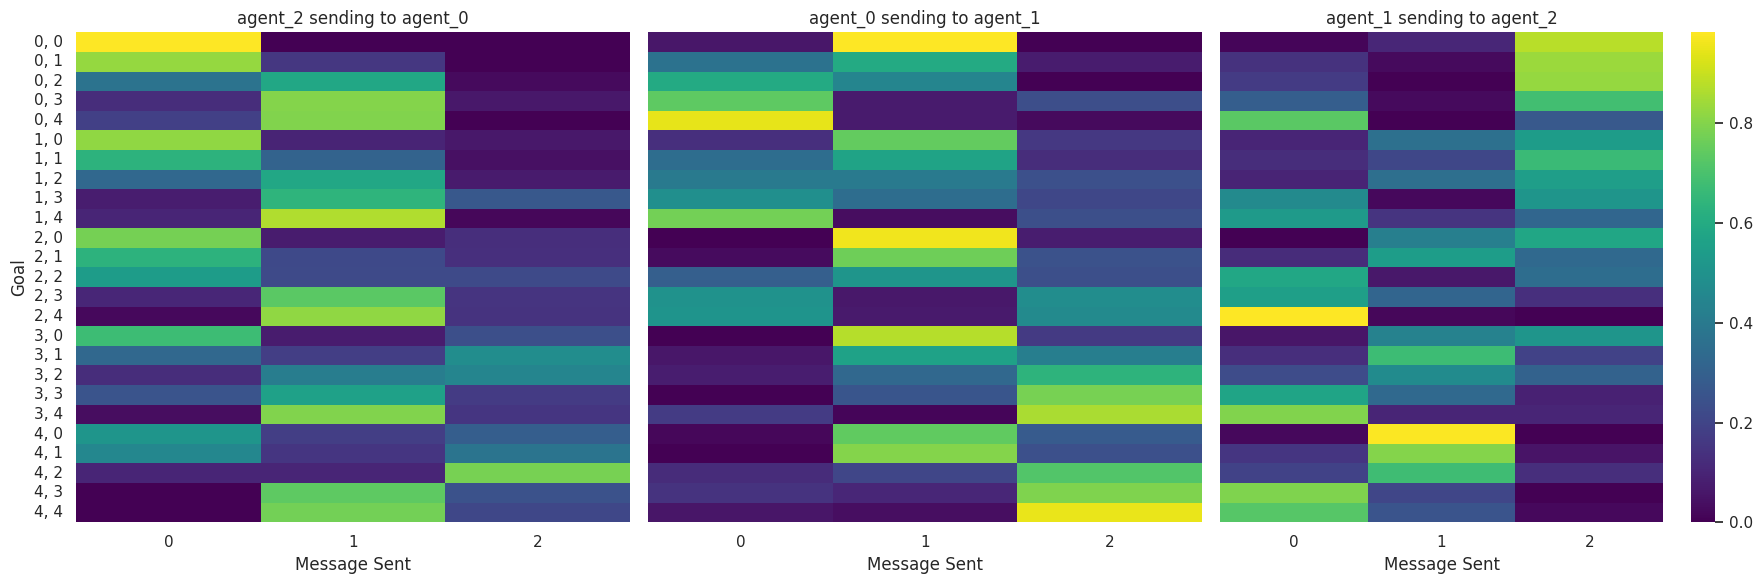

In [48]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(6 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df['sender'] == agent]
    recvs = agent_df['receiver'].unique()
    assert recvs.size == 1
    recv = recvs[0]
    agent_df = agent_df.groupby('goal_grid_idx')['msg'].value_counts(normalize=True).unstack()
    counts_df = agent_df.fillna(0)
    counts = np.zeros((world_w * world_h, n_msgs))
    for msg in counts_df.columns:
        for goal_idx in counts_df.index:
            counts[goal_idx, msg] = counts_df.loc[goal_idx, msg]
    sns.heatmap(counts, cmap='viridis', ax=axs[i], cbar=i == len(agents) - 1)
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Goal')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])
    axs[i].set_xlabel('Message Sent')
    axs[i].set_title(f'{agent} sending to {recv}')
plt.tight_layout()
plt.show()

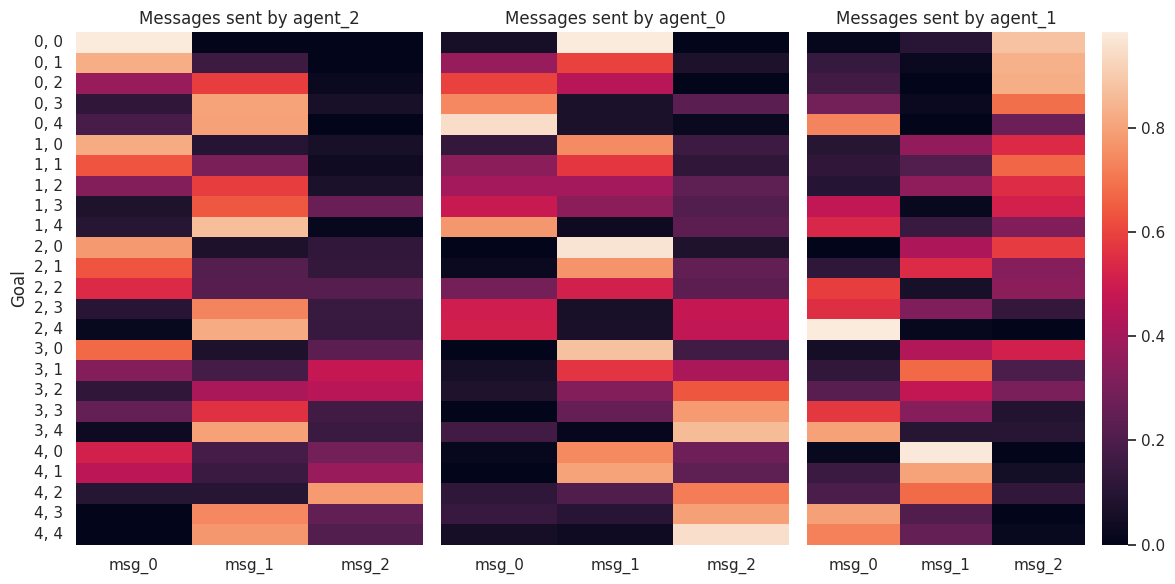

In [50]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
msg_cols = [f'msg_{i}' for i in range(n_msgs)]
for i, agent in enumerate(agents):
    action_mean_msgs = df[df.sender == agent].groupby('goal_grid_idx')[msg_cols].mean()
    action_mean_msgs = action_mean_msgs.reset_index().set_index('goal_grid_idx')
    sns.heatmap(action_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Goal')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])
plt.tight_layout()
plt.show()

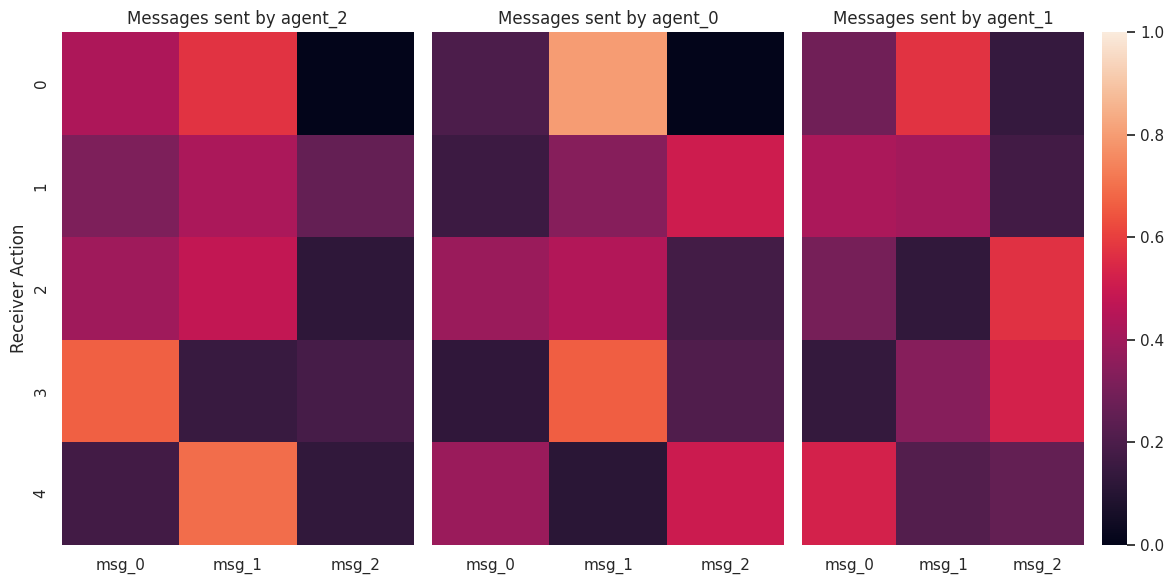

In [52]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    action_mean_msgs = df[df.sender == agent].groupby('receiver_action')[msg_cols].mean()
    action_mean_msgs = action_mean_msgs.reset_index().set_index('receiver_action')
    sns.heatmap(action_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1, vmin=0, vmax=1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Receiver Action')

plt.tight_layout()
plt.show()

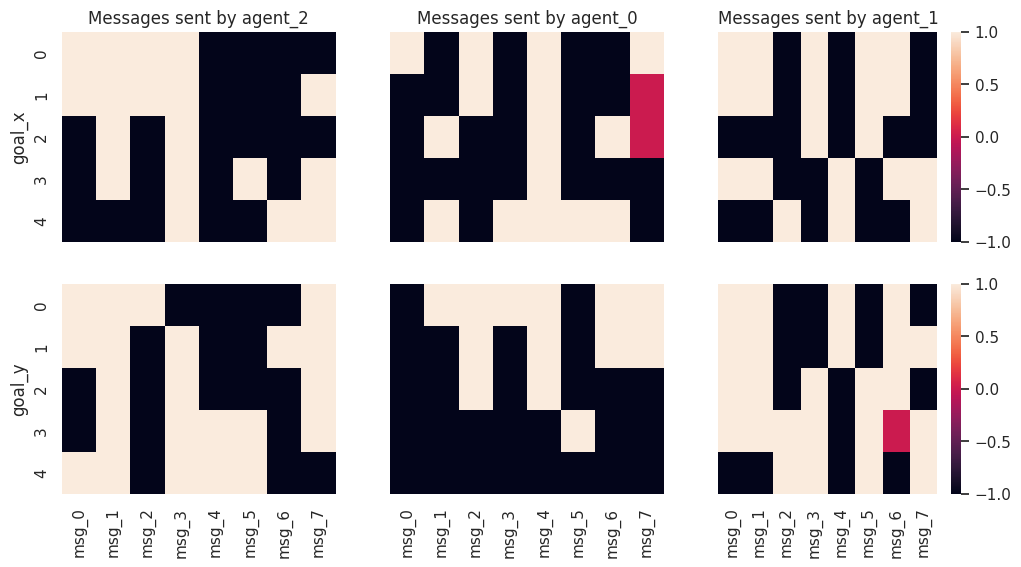

In [159]:
agents = df['sender'].unique()
_, axs_grid = plt.subplots(2, len(agents), figsize=(4 * len(agents), 6))
# msg_cols = [col for col in df.columns if col.startswith('msg')]
for i, agent in enumerate(agents):
    agent_df = df[df.sender == agent]
    
    goal_x_mean_msgs = agent_df.groupby('goal_x')[msg_cols].median()
    goal_x_mean_msgs = goal_x_mean_msgs.reset_index().set_index('goal_x')
    sns.heatmap(goal_x_mean_msgs, ax=axs_grid[0][i], cbar=i == len(agents) - 1, vmin=-1, vmax=1)

    goal_y_mean_msgs = agent_df.groupby('goal_y')[msg_cols].median()
    goal_y_mean_msgs = goal_y_mean_msgs.reset_index().set_index('goal_y')
    sns.heatmap(goal_y_mean_msgs, ax=axs_grid[1][i], cbar=i == len(agents) - 1, vmin=-1, vmax=1)

    axs_grid[0][i].set_title(f'Messages sent by {agent}')
    axs_grid[0][i].set_xticks([])
    if i > 0:
        axs_grid[0][i].set_ylabel('')
        axs_grid[0][i].set_yticks([])
        axs_grid[1][i].set_ylabel('')
        axs_grid[1][i].set_yticks([])

<AxesSubplot: >

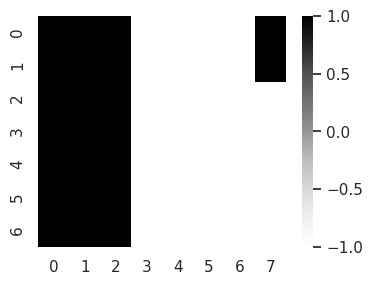

In [82]:
messages_01 = np.vstack([
    item['comms']['agent_0']['agent_1']
    for item in collect_comms_data_cb.data
    if item['episode_id'] == episodes[0]
])

plt.figure(figsize=(4, 3))
sns.heatmap(messages_01, vmin=-1, vmax=1, cmap='Greys')